## Predicting Used Car Stock Retention: A Time-To-Event Approach

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from scipy import stats
from IPython.display import display
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
import joblib


### 1. Load the Data


In [2]:
DATA_PATH = "D:/MyData/Data Science Mladen/MyGitHubProjects/survivl_analysis/carsdata.csv"
data = pd.read_csv(DATA_PATH)
data.head()

,Id,IsSold,WeeksOnStockBeforeSale,onAction,SalesSeason,TotalPrice,CarAgeYears,Kilometers,Kilowatts,Horsepower,...,AlloyWheels21,CooledRearSeats,FrontElectricWindows,AlloyWheels15,VirtualCockpit,Alcantara,LeatherAlcantara,Leather,Fabric,LeatherFabric
0,1001,1,4.14,1,Winter,17431.0,4,148947,81,110,...,0,0,0,0,0,0,0,0,1,0
1,1003,1,2.14,0,Winter,14867.0,6,109773,81,110,...,0,0,0,0,0,0,0,0,0,1
2,1005,1,6.14,0,Winter,14354.0,6,159895,81,110,...,0,0,0,0,0,0,0,1,0,0
3,1007,1,5.14,0,Winter,15379.0,5,154958,81,110,...,0,0,0,0,0,0,0,0,1,0
4,1009,1,5.14,0,Winter,15379.0,4,155312,81,110,...,0,0,0,0,0,0,0,0,1,0


### 2. Exploratory Data Analysis

2.1. Descriptive Statistics 

In [3]:
# Missing data in dataset
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])

# Selects all binary numerical columns (containing only 0 and 1)
binary_cols = [col for col in data.select_dtypes(include=[np.number]).columns if data[col].dropna().isin([0, 1]).all()]
# Converting binary to categorical data
data[binary_cols] = data[binary_cols].astype("category")

# Selects all numerical columns (int and float)
numerical_variables = data.select_dtypes(include=[np.number])
# Selects all non-numerical (categorical) columns
categorical_variables = data.select_dtypes(exclude=[np.number])

# Generates summary statistics for categorical and numerical variables
describe_numerical = numerical_variables.describe().transpose()
describe_categorical =categorical_variables.describe().transpose()

2.2. Pearson Correlation - Heatmap

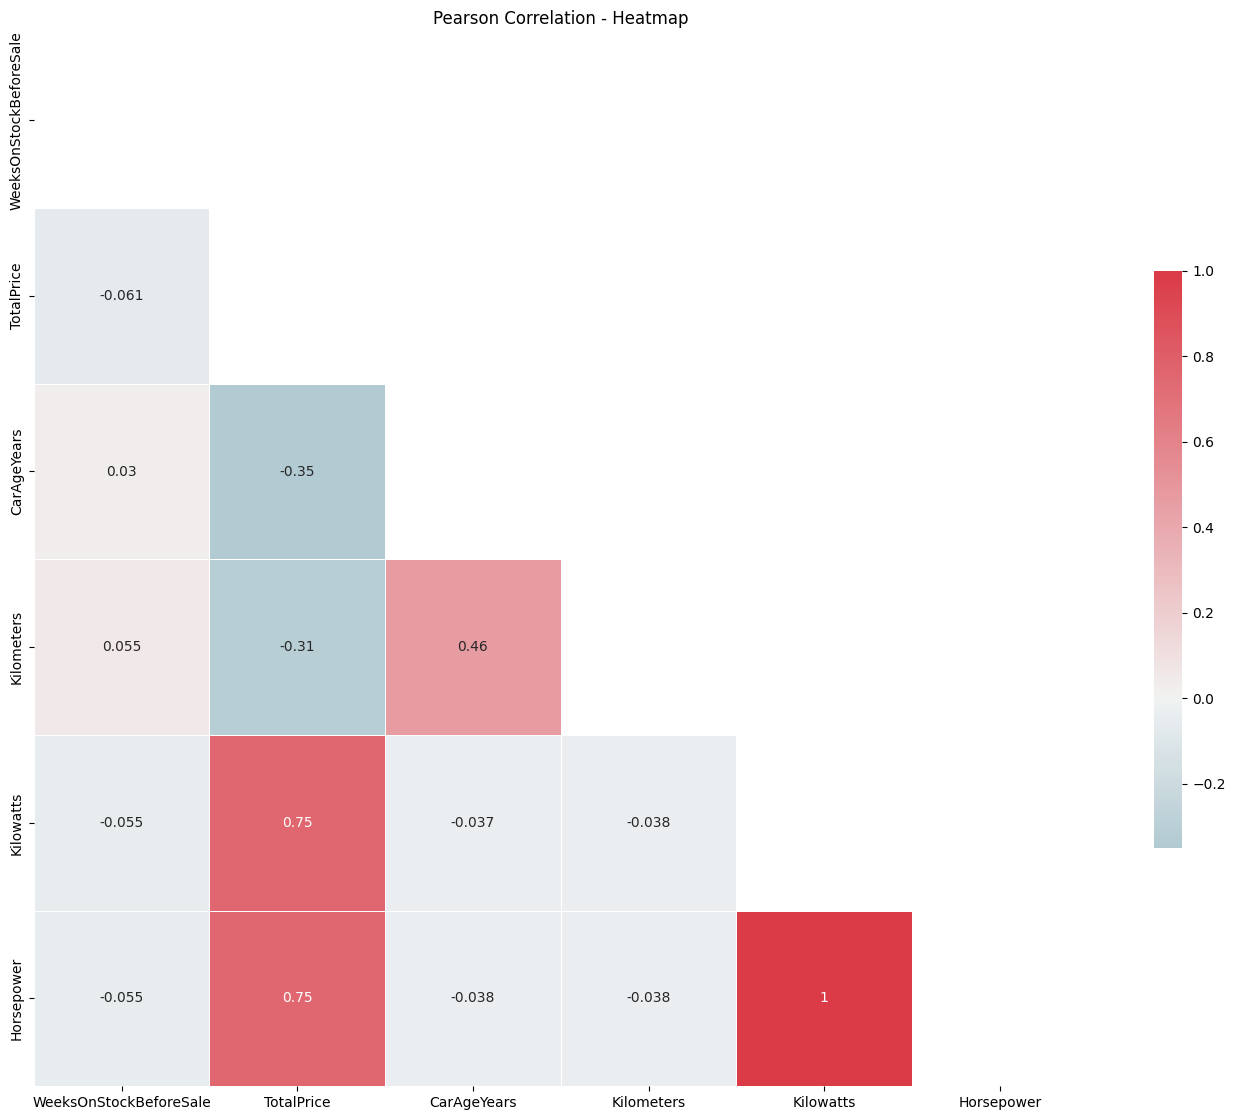

In [4]:
# Remove the ID column
numeric_variables = numerical_variables.iloc[:, 1:]

# Pearson correlation
corr = numeric_variables.corr(method="pearson")

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  

# Set figure size
f, ax = plt.subplots(figsize=(17, 15))

# Define a custom diverging color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Pearson Correlation - Heatmap")
plt.show()

2.3. Correlation between "Horsepower" and "Price" - Scatter Plot

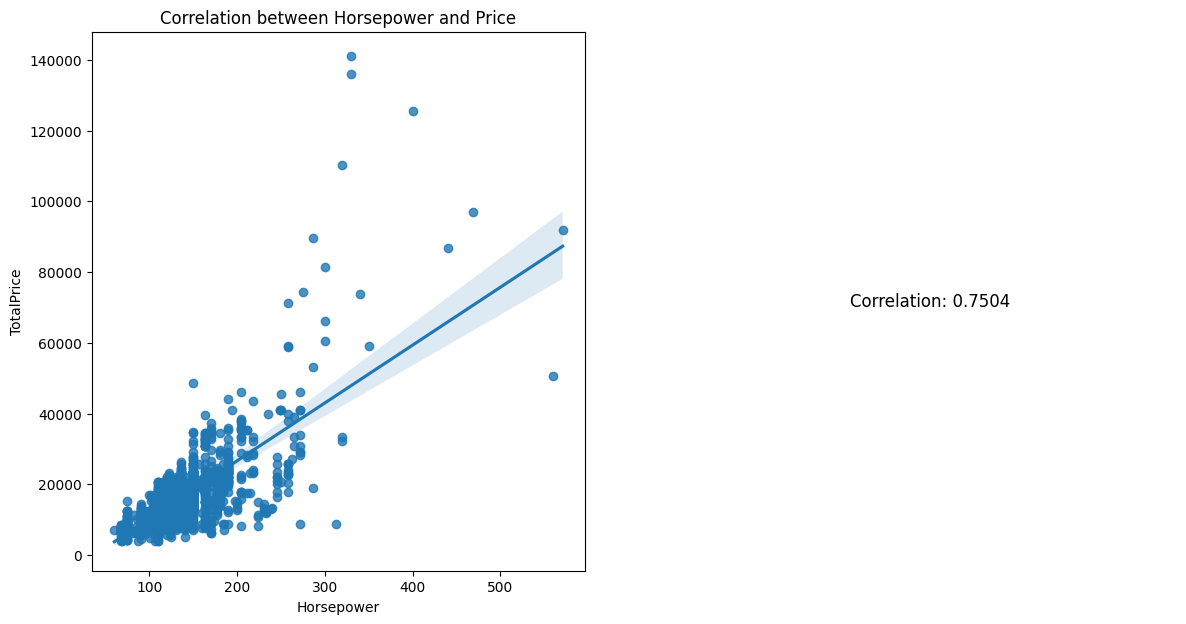

In [5]:
# Create a figure with two subplots  
fig = plt.figure(figsize=(14, 7))

# First subplot (scatter plot with regression line)  
ax1 = fig.add_subplot(121)
sns.regplot(x="Horsepower", y="TotalPrice", data=data, ax=ax1)  
ax1.set_title("Correlation between Horsepower and Price")

# Second subplot (text only)  
ax2 = fig.add_subplot(122)
ax2.axis("off")  # Disable axes
ax2.text(x=0.5, y=0.5, s=f"Correlation: {data.Horsepower.corr(data['TotalPrice']):.4f}", 
         fontsize=12, ha="center", va="center")

plt.show()

2.4. Estimated Probability of Stock Retention (Kaplan-Meier Estimator – The Survival Function)

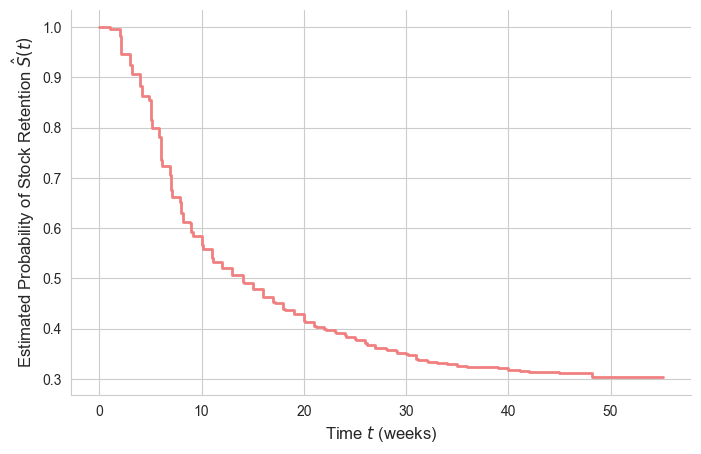

In [6]:
# Convert "IsSold" column to boolean type
data["IsSold"] = data["IsSold"].astype("bool")

# Compute the Kaplan-Meier survival estimate
time, survival_prob = kaplan_meier_estimator(data["IsSold"], 
                                             data["WeeksOnStockBeforeSale"])

# Apply a pastel style
sns.set_style("whitegrid")  
plt.figure(figsize=(8, 5)) 

# Plot the survival function
plt.step(time, survival_prob, where="post", 
         color="lightcoral", linewidth=2)

# Set labels
plt.ylabel(r"Estimated Probability of Stock Retention $\hat{S}(t)$", 
           fontsize=12)
plt.xlabel(r"Time $t$ (weeks)", 
           fontsize=12)

# Adjust tick parameters
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove top and right borders
sns.despine()

# Show the plot
plt.show()


2.5. Differences in stock retention between vehicle body types    (Kaplan-Meier Estimator – The Survival Function)

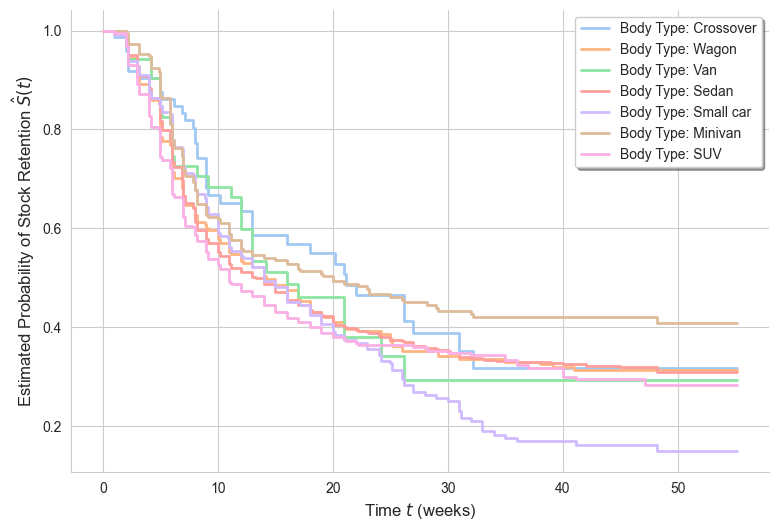

In [7]:
# Apply a style
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6)) 

# Define a color palette
colors = sns.color_palette("pastel", 7)

# Loop through each vehicle body type and plot its Kaplan-Meier survival curve
for i, body_type in enumerate(("Crossover", "Wagon", "Van", "Sedan",
                               "Small car", "Minivan", "SUV")):                      
    # Create a mask to filter data for the current body type
    mask_body_type = data["BodyType"] == body_type
    
    # Compute the Kaplan-Meier survival estimate for the current body type
    time_body_type, survival_prob_body_type = kaplan_meier_estimator(
        data["IsSold"][mask_body_type],
        data["WeeksOnStockBeforeSale"][mask_body_type])
    
    # Plot the survival function
    plt.step(time_body_type, survival_prob_body_type, where="post",
             label=f"Body Type: {body_type}", color=colors[i], linewidth=2)

# Set axis labels
plt.ylabel(r"Estimated Probability of Stock Retention $\hat{S}(t)$", fontsize=12)
plt.xlabel(r"Time $t$ (weeks)", fontsize=12)

# Add a legend
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)

# Remove unnecessary chart borders
sns.despine()

# Display the plot
plt.show()


2.6. Differences in stock retention between vehicle engine types    (Kaplan-Meier Estimator – The Survival Function)

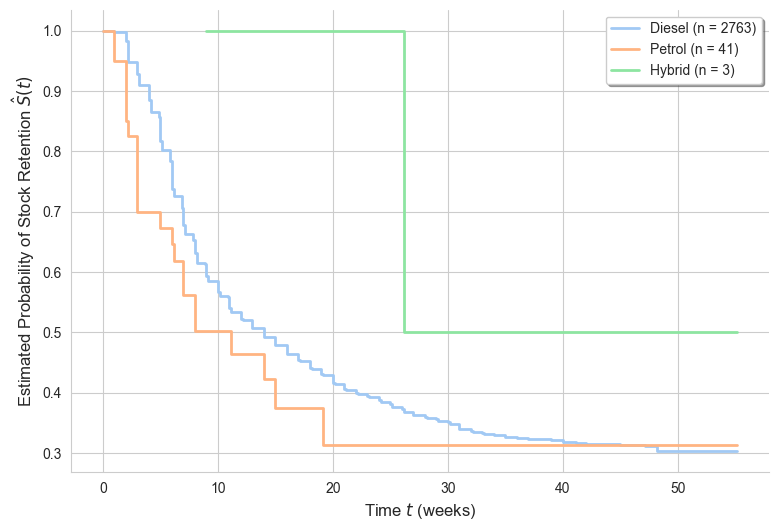

In [8]:
# Apply a style
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6)) 

# Define a color palette
colors = sns.color_palette("pastel", len(data["EngineType"].unique()))

# Loop through each unique engine type and plot its Kaplan-Meier survival curve
for i, value in enumerate(data["EngineType"].unique()):    
    # Create a mask to filter data for the current engine type
    mask = data["EngineType"] == value

    # Compute the Kaplan-Meier survival estimate for the current engine type
    time_engine_type, survival_prob_engine_type = kaplan_meier_estimator(
        data["IsSold"][mask], data["WeeksOnStockBeforeSale"][mask])

    # Plot the survival function
    plt.step(time_engine_type, survival_prob_engine_type, where="post",
             label=f"{value} (n = {mask.sum()})", color=colors[i], linewidth=2)

# Set axis labels
plt.ylabel(r"Estimated Probability of Stock Retention $\hat{S}(t)$", fontsize=12)
plt.xlabel(r"Time $t$ (weeks)", fontsize=12)

# Add a legend
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)

# Remove unnecessary chart borders
sns.despine()

# Display the plot
plt.show()

2.7. Differences in stock retention across seasons - spring, summer, fall, winter  (Kaplan-Meier Estimator – The Survival Function)

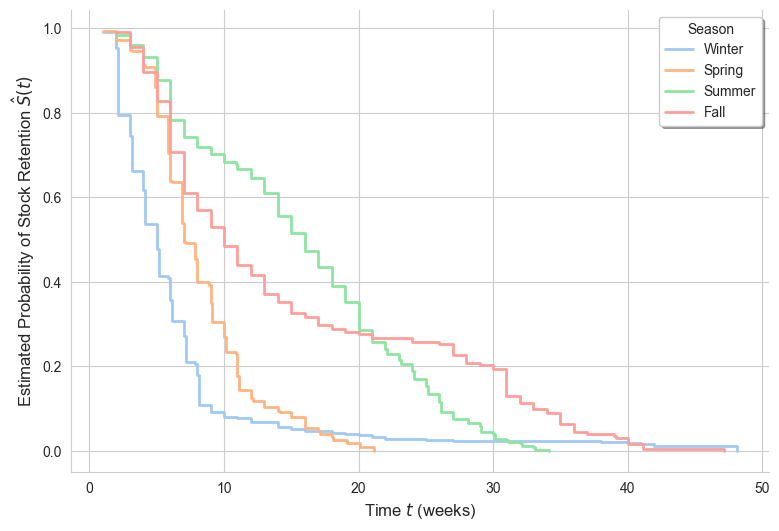

In [9]:
# Apply a style
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6))  

# Define a color palette for different seasons
colors = sns.color_palette("pastel", 4)

# Loop through each season and plot its Kaplan-Meier survival curve
for i, season in enumerate(("Winter", "Spring", "Summer", "Fall")):               
    # Create a mask to filter data for the current season
    mask_season = data["SalesSeason"] == season

    # Compute the Kaplan-Meier survival estimate for the current season
    time_season, survival_prob_season = kaplan_meier_estimator(
        data["IsSold"][mask_season],
        data["WeeksOnStockBeforeSale"][mask_season])

    # Plot the survival function
    plt.step(time_season, survival_prob_season, where="post",
             label=season, color=colors[i], linewidth=2)

# Set axis labels
plt.ylabel(r"Estimated Probability of Stock Retention $\hat{S}(t)$", fontsize=12)
plt.xlabel(r"Time $t$ (weeks)", fontsize=12)

# Add a legend
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True, title="Season")

# Remove unnecessary chart borders
sns.despine()

# Display the plot
plt.show()

### 3. Data Preprocessing & Feature Engineering

In [10]:

# Fill missing values in TotalPrice based on Cars and CarAgeGroup
data["TotalPrice"] = data.groupby(["Cars"])["TotalPrice"].transform(lambda x: x.fillna(x.mean()))

# Filling NaN values for 3 car types that had no price data
data["TotalPrice"].fillna(data["TotalPrice"].mean(), inplace=True)  

# Convert categorical columns to the "category" data type
for col in ["SalesSeason","Cars", "EngineType", "BodyType", 
            "TransmissionType","Color","NumberofDoors"]:
    data[col] = data[col].astype("category")

# Find the column index of "Alarm"
loc = data.columns.get_loc("Alarm")

# Convert all columns from "Alarm" onward to boolean type
for col in data.iloc[:,loc:]:                 
    data[col] = data[col].astype("bool")

# Convert "onAction" to boolean
data["onAction"] = data["onAction"].astype("bool")

# Store data types for reference
types = data.dtypes

# Select categorical columns for encoding
selected_columns = data[["SalesSeason","Cars", "EngineType", "BodyType", 
                      "TransmissionType","Color","NumberofDoors"]]

# Apply one-hot encoding to categorical variables
onehot_encoded_data  = OneHotEncoder().fit_transform(selected_columns)
#onehot_encoded_data = onehot_encoded_data.astype("bool")

# Fill missing values in one-hot encoded columns
onehot_encoded_data[["SalesSeason=Spring", 
                     "SalesSeason=Summer", 
                     "SalesSeason=Winter"]] = onehot_encoded_data[["SalesSeason=Spring", 
                                                                   "SalesSeason=Summer", 
                                                                   "SalesSeason=Winter"]].fillna(0)

onehot_encoded_data = onehot_encoded_data.astype(int)

# Add the encoded columns to the original dataset
data = data.join(onehot_encoded_data)

# Remove the original categorical columns and the "Id" column
data.drop(columns=["Id","SalesSeason","Cars", "EngineType", "BodyType", 
                      "TransmissionType","Color","NumberofDoors"], inplace=True)

# Convert boolean columns to integer type
bool_columns = data.select_dtypes(include=['bool']).columns
data[bool_columns] = data[bool_columns].astype(int)


# Create target variable (Y) for survival analysis
data_y = data[["IsSold", "WeeksOnStockBeforeSale"]]
data_y = Surv.from_dataframe("IsSold", "WeeksOnStockBeforeSale", data_y)

# Create feature set (X) by removing target variables
data_x = data.drop(["IsSold", "WeeksOnStockBeforeSale"], axis=1).copy()

# Standardize numerical columns using Z-score normalization
for column in ["TotalPrice", "CarAgeYears","Kilometers","Kilowatts","Horsepower"]:
    data_x[column]= (data_x[column] - data_x[column].mean()) / data_x[column].std()

# Remove "Kilowatts" due to high correlation with "Horsepower"
data_x = data_x.drop(['Kilowatts'], axis=1).copy()


### 4. Hyperparameter Tuning, Model Training & Selection

In [ ]:
warnings.simplefilter("ignore", ConvergenceWarning)

# Split data into train and test
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=random_state)

y_train = np.array(y_train, dtype=[("Status", "?"), ("Time", "<f8")])
y_test = np.array(y_test, dtype=[("Status", "?"), ("Time", "<f8")])

# Cox Proportional Hazards Hyperparameters
param_grid_cox = {'coxphsurvivalanalysis__alpha': [0.01, 0.1, 1, 10, 100],
                  'coxphsurvivalanalysis__ties': ["breslow", "efron"]
                  }

# Random survival forest Hyperparameters
param_grid_rsf = {
    'randomsurvivalforest__n_estimators': [100, 300, 500, 700],
    'randomsurvivalforest__min_samples_split': [2, 5, 10, 20],
    'randomsurvivalforest__min_samples_leaf': [1, 5, 10, 20],
    'randomsurvivalforest__max_depth': [None, 10, 20, 30] 
    }

# Gradient-boosted Hyperparameters
param_grid_gbcox = {
    'gradientboostingsurvivalanalysis__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'gradientboostingsurvivalanalysis__n_estimators': [100, 300, 500],
    'gradientboostingsurvivalanalysis__max_depth': [3, 5, 7, 9],
    'gradientboostingsurvivalanalysis__dropout_rate': [0.0, 0.1, 0.2, 0.3] 
    }

# Function that computes the concordance index
def c_index_scorer(estimator, X, y):
    return concordance_index_censored(y["Status"], y["Time"], estimator.predict(X))[0]


# Define cross-validation strategy
cv = KFold(n_splits=4, shuffle=True, random_state=0)

# Define pipelines for each model
cox_pipe = make_pipeline(CoxPHSurvivalAnalysis())
rsf_pipe = make_pipeline(RandomSurvivalForest(random_state=random_state, n_jobs=-1))
gbcox_pipe = make_pipeline(GradientBoostingSurvivalAnalysis(random_state=random_state))


# Perform Grid Search for each model
cox_search = GridSearchCV(cox_pipe, param_grid_cox, cv=cv, scoring=c_index_scorer, n_jobs=-1)
rsf_search = GridSearchCV(rsf_pipe, param_grid_rsf, cv=cv, scoring=c_index_scorer, n_jobs=-1)
gbcox_search = GridSearchCV(gbcox_pipe, param_grid_gbcox, cv=cv, scoring=c_index_scorer, n_jobs=-1)


# Fit models
cox_search.fit(X_train, y_train)
rsf_search.fit(X_train, y_train)
gbcox_search.fit(X_train, y_train)

# Collect results
models = {
    'Cox Proportional Hazards': cox_search,
    'Random Survival Forest': rsf_search,
    'Gradient-Boosted Cox': gbcox_search
}

# Create empty DataFrame
cv_results_df = pd.DataFrame()

# Iterate over models and collect results
for name, search in models.items():
    df = pd.DataFrame(search.cv_results_)
    df["Model"] = name  
    cv_results_df = pd.concat([cv_results_df, df], ignore_index=True)

# Save results to CSV
cv_results_df.to_csv("cross_validation_results.csv", index=False)


# Select the best model based on test performance
best_model_name, best_model, best_score = None, None, float("-inf")  
for name, search in models.items():
    score = search.best_score_  
    print(f"{name} Best Score: {score:.4f}")
    if score > best_score:  
        best_model_name, best_model, best_score = name, search.best_estimator_, score

print(f"Best model: {best_model_name} with score {best_score:.4f}")
       

# Save best model
joblib.dump(best_model, "best_survival_model.pkl")



Cox Proportional Hazards Best Score: 0.8379
Random Survival Forest Best Score: 0.8367
Gradient-Boosted Cox Best Score: 0.8464
Best model: Gradient-Boosted Cox with score 0.8464


['best_survival_model.pkl']

4.1. Concordance Index Distribution Across Models

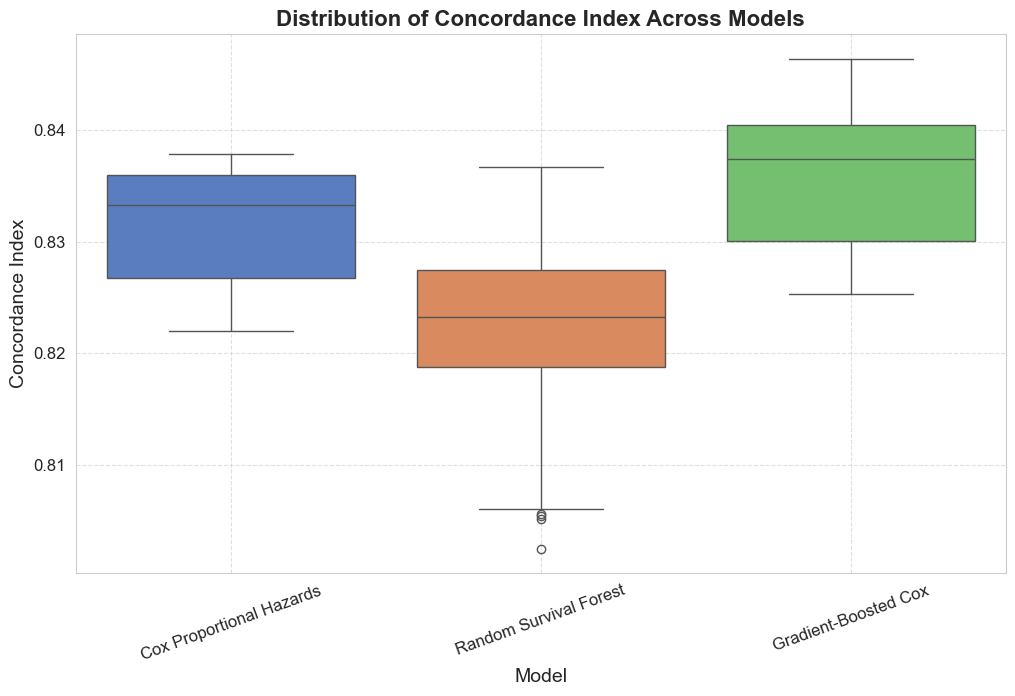

In [20]:
# Prepare data for boxplot
cv_results = []
for name, search in models.items():
    scores = np.array(search.cv_results_["mean_test_score"])  # C-index
    for score in scores:
        cv_results.append({"Model": name, "Concordance Index": score})

df_results = pd.DataFrame(cv_results)

# Enhanced boxplot visualization
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.boxplot(
    x="Model", 
    y="Concordance Index", 
    data=df_results, 
    hue="Model",  
    dodge=False,  
    legend=False,  
    palette="muted"
)

plt.title("Distribution of Concordance Index Across Models", fontsize=16, fontweight="bold")
plt.xlabel("Model", fontsize=14)
plt.ylabel("Concordance Index", fontsize=14)

# Rotate x-axis labels if needed
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
ax.grid(True, linestyle="--", alpha=0.6)

plt.show()


### 5. Best Model Predictions on the Test Dataset

In [ ]:
# Load the best model
best_model = joblib.load("best_survival_model.pkl")

# Predict on test set and compute survival probabilities
y_pred = best_model.predict(X_test)  
y_pred_surv_prob = best_model.predict_survival_function(X_test, return_array=True)

# Compute the concordance index
c_index = concordance_index_censored(y_test["Status"], y_test["Time"], y_pred)[0]
print(f"Concordance Index on the test dataset: {c_index:.4f}")

# Restore Car_Type column from one-hot encoded features
cars_columns = [col for col in X_test.columns if col.startswith("Cars=")]
X_test["Car_Type"] = X_test[cars_columns].idxmax(axis=1).str.replace("Cars=", "")

# Create a survival probability dataframe
df_surv = pd.DataFrame(y_pred_surv_prob, columns=[f"Week {i+1}" for i in range(y_pred_surv_prob.shape[1])])
df_surv.insert(0, "Car_Type", X_test["Car_Type"].values)  # Insert car names


# Plot survival curves for the first 10 cars
fig = go.Figure()

for i in range(min(10, len(X_test))):
    fig.add_trace(go.Scatter(
        x=time_points, 
        y=y_pred_surv_prob[i], 
        mode='lines', 
        name=df_surv["Car_Type"].iloc[i], 
        hovertemplate="Car Type: " + df_surv["Car_Type"].iloc[i] + "<br>Weeks on Stock: %{x}<br>Probability: %{y:.2f}"
    ))

fig.update_layout(
    title="Predicted Survival Curve for 10 Newly Arrived Vehicles - Example",
    xaxis_title="Weeks on Stock",
    yaxis_title="Probability of Vehicle Stock Retention",
    legend_title="Car Type",
    xaxis=dict(dtick=5, gridcolor='lightgray'),
    yaxis=dict(dtick=0.1, gridcolor='lightgray'),
    template="plotly_white"
)

fig.show()

# Remove Car_Type from X_test
X_test.drop(columns=["Car_Type"], inplace=True)


Concordance Index on the test dataset: 0.8382
